### Fine tune LLM embeedings model


In [2]:
#!pip install openai==0.28.1
#!pip install openai --upgrade
#!pip install ragas
#!pip install unstructured
#!pip install langchain[all]
#!pip install --upgrade langchain

#!pip install playwright
#!pip install -U selenium unstructured
#!pip install --upgrade langchain langchain-community langchainhub langchain-openai langchain-chroma bs4

In [1]:
#!pip install pydantic==2.5
#!pip install --upgrade --quiet  langchain_milvus
#!pip install --upgrade scipy

In [1]:
import os, json
#import openai
#from langchain.chat_models import ChatOpenAI, ChatGooglePalm
from utils import OPENAI_API_KEY

os.environ['OPENAI_API_KEY'] =  OPENAI_API_KEY
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

#openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from transformers import (BertTokenizer, 
                          BertForMaskedLM, 
                          Trainer, 
                          TrainingArguments, 
                          DataCollatorForLanguageModeling,
                          DataCollatorForWholeWordMask,
                          DataCollatorWithPadding
                         )
from datasets import load_dataset


### 1. Download articels from URL

In [4]:
import bs4
#from langchain import hub
from langchain_community.document_loaders import SeleniumURLLoader, TextLoader
#from langchain_chroma import Chroma
from langchain_milvus.vectorstores import Milvus
#from langchain_core.output_parsers import StrOutputParser
#from langchain_core.runnables import RunnablePassthrough
#from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter, NLTKTextSplitter
#from langchain.storage import InMemoryStore
#from langchain.retrievers import ParentDocumentRetriever

#from langchain.chains import create_history_aware_retriever, create_retrieval_chain
#from langchain.chains.combine_documents import create_stuff_documents_chain
#from langchain_community.chat_message_histories import ChatMessageHistory
#from langchain_core.chat_history import BaseChatMessageHistory
#from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
#from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


In [11]:
ai_model = "gpt-3.5-turbo-0125"
tokens = 500

llm = ChatOpenAI(model=ai_model, temperature=0.)

In [12]:
def load_url_documets(list_urls):
    
    # Load, chunk and index the contents of the blog.
    loader_url =SeleniumURLLoader( list_urls)
    docs = loader_url.load()
    #text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n","\n"], chunk_size=500, chunk_overlap=50)
    text_splitter = NLTKTextSplitter(chunk_size=tokens, chunk_overlap=50)
    splits = text_splitter.split_documents(docs)
    
    return splits, docs

In [ ]:
url_list = ["https://www.nature.com/articles/s41524-023-01062-z",
            "https://www.nature.com/articles/s41699-023-00369-1",
          #  "https://github.com/HSE-LAMBDA/ai4material_design/tree/main/docs/CONSTRUCTOR-MOCK.md"
          #  "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/CONSTRUCTOR.md",
          #  "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/DATA.md",
          #  "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/ENVIRONMENT.md",
          #  "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/GENERATING-CONSTRUCTOR.md",
          #  "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/GENERATING-MOCK.md",
          #  "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/PILOT.md",
          #  "https://github.com/HSE-LAMBDA/ai4material_design/blob/main/docs/SPARSE-PAPER.md"
          #  "https://www.nature.com/articles/s41377-024-01407-3",
          #  "https://www.nature.com/articles/s41565-023-01407-1",
          #  "https://www.nature.com/articles/s41699-023-00369-1",
           ]
                               
chunks, documents = load_url_documets(url_list)
print(len(chunks), len(documents))

There was an error managing chromedriver (error sending request for url (https://googlechromelabs.github.io/chrome-for-testing/known-good-versions-with-downloads.json): error trying to connect: dns error: failed to lookup address information: Try again); using driver found in the cache
Error sending stats to Plausible: error sending request for url (https://plausible.io/api/event): operation timed out


In [ ]:
len(chunks[3].page_content.split(" "))

In [38]:
import json
train_size = 0.8  # 80% of the data for training

# Save the train data
with open('data/data_rag/file_train_chunks.json', 'w') as fp:
    
    for c  in chunks[:int(train_size*len(chunks))]:
        # write each item on a new line
        fp.write('{text: %s}\n' % c.page_content.replace("\n", " "))
        
with open('data/data_rag/file_validation_chunks.json', 'w') as fp:
    
    for c  in chunks[int(train_size*len(chunks)):]:
        # write each item on a new line
        fp.write('{text: "%s}\n' % c.page_content.replace("\n", " "))
    #fp.writelines("text:".join(json.dumps(i) for i in chunks[:80]) + ',\n'
    #         
    #    )

### Load Model

In [4]:
# Load a tokenizer specific to BAAI/bge-base-en-v1.5
tokenizer = BertTokenizer.from_pretrained('BAAI/bge-base-en-v1.5')


In [5]:
tokenizer.tokenize_chinese_chars = False

In [6]:
# Load a dataset
dataset = load_dataset('text', 
                       data_files={'train': './data/data_rag/file_train_chunks.json', 
                                   'validation': './data/data_rag/file_validation_chunks.json'})


In [7]:
# Tokenize the dataset and apply masking
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])


In [8]:
dataset['train'][10]['text']

'{text: In this work, we propose a method for predicting the energetic and electronic structures of defects in 2D materials with machine learning.  Firstly, a machine learning-friendly 2D Material Defect database (2DMD) was established employing high throughput DFT calculations15.  The database is composed of both structured datasets and dispersive datasets of defects in represented 2D materials such as MoS2, WSe2, h-BN, GaSe, InSe, and black phosphorous (BP).}'

In [9]:
print(len(tokenized_datasets['train'][10]['input_ids'])) # 512
print(tokenized_datasets['train'][11]['input_ids'])


512
[101, 1063, 3793, 1024, 2057, 2224, 1996, 2951, 13462, 2015, 2000, 16157, 1996, 2836, 1997, 1996, 3130, 2988, 8107, 2247, 2007, 14635, 1521, 2029, 2001, 11974, 2881, 2000, 3073, 8321, 6412, 1997, 4475, 2007, 18419, 1012, 2256, 15078, 7885, 2265, 2008, 2256, 3921, 3640, 1037, 3278, 3623, 1999, 17547, 10640, 4102, 2000, 1996, 2110, 1011, 1997, 1011, 1996, 1011, 2396, 2236, 4725, 1012, 1065, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
# Data collator for dynamic masking
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.2
)


Some weights of BertForMaskedLM were not initialized from the model checkpoint at BAAI/bge-large-en-v1.5 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [11]:
# Load the BAAI/bge-base-en-v1.5 model for masked language modeling
model = BertForMaskedLM.from_pretrained('BAAI/bge-base-en-v1.5')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at BAAI/bge-base-en-v1.5 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results512a',
    evaluation_strategy="epoch",
    learning_rate=2e-4,
  #  lr_scheduler_type  = 'cosine_with_restarts',
    gradient_accumulation_steps = 4, 
    per_device_train_batch_size=4, # batch size 4 and 512 tokens length takes 3400 Mbs of GPU
    per_device_eval_batch_size=4,  # 8 batch size more usefull for trainig, then 2
    num_train_epochs=100,
    weight_decay=0.01,
)

/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
)

In [14]:
model.device

device(type='cuda', index=0)

In [15]:
# calculate only the trainable parameters:

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("model parameters:", round(pytorch_total_params/1e6,3), "M")

model parameters: 109.514 M


In [16]:
# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss
0,No log,6.960860
1,No log,6.422420
2,No log,6.282650
4,No log,6.084062
5,No log,6.204672
6,No log,6.136813
8,No log,5.823820
9,No log,5.943426
10,No log,5.820554
12,No log,5.595556


TrainOutput(global_step=1100, training_loss=2.5661329928311436, metrics={'train_runtime': 7634.0017, 'train_samples_per_second': 2.423, 'train_steps_per_second': 0.144, 'total_flos': 4558970562508800.0, 'train_loss': 2.5661329928311436, 'epoch': 93.61702127659575})

In [20]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results512a',
    evaluation_strategy="epoch",
    learning_rate=2e-4,
  #  lr_scheduler_type  = 'cosine_with_restarts',
    gradient_accumulation_steps = 4, 
    per_device_train_batch_size=4, # batch size 4 and 512 tokens length takes 3400 Mbs of GPU
    per_device_eval_batch_size=4,  # 8 batch size more usefull for trainig, then 2
    num_train_epochs=100,
    weight_decay=0.01,
)

/home/oleg/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
)

In [18]:
# Train the model
trainer.log_metrics()


TypeError: log_metrics() missing 2 required positional arguments: 'split' and 'metrics'

In [1]:
data_train = """0 	No log 	6.960860
1 	No log 	6.422420
2 	No log 	6.282650
4 	No log 	6.084062
5 	No log 	6.204672
6 	No log 	6.136813
8 	No log 	5.823820
9 	No log 	5.943426
10 	No log 	5.820554
12 	No log 	5.595556
13 	No log 	5.642794
14 	No log 	5.647243
16 	No log 	5.626409
17 	No log 	5.527695
18 	No log 	5.480936
20 	No log 	4.916962
21 	No log 	5.028299
22 	No log 	4.890584
24 	No log 	4.297911
25 	No log 	4.076789
26 	No log 	3.980025
28 	No log 	3.708674
29 	No log 	3.936939
30 	No log 	3.819258
32 	No log 	3.492900
33 	No log 	3.740168
34 	No log 	3.249136
36 	No log 	3.388892
37 	No log 	3.173328
38 	No log 	3.214972
40 	No log 	3.090436
41 	No log 	3.067657
42 	4.220800 	3.093683
44 	4.220800 	2.924738
45 	4.220800 	2.916366
46 	4.220800 	2.948514
48 	4.220800 	2.997685
49 	4.220800 	2.786241
50 	4.220800 	2.979261
52 	4.220800 	2.623811
53 	4.220800 	2.801431
54 	4.220800 	2.648566
56 	4.220800 	2.467402
57 	4.220800 	2.805202
58 	4.220800 	2.779776
60 	4.220800 	2.727691
61 	4.220800 	2.772953
62 	4.220800 	2.615841
64 	4.220800 	2.581881
65 	4.220800 	2.690757
66 	4.220800 	2.663996
68 	4.220800 	2.515438
69 	4.220800 	2.545212
70 	4.220800 	2.506399
72 	4.220800 	2.607189
73 	4.220800 	2.498257
74 	4.220800 	2.476972
76 	4.220800 	2.469248
77 	4.220800 	2.562613
78 	4.220800 	2.393988
80 	4.220800 	2.484040
81 	4.220800 	2.393851
82 	4.220800 	2.388913
84 	4.220800 	2.500747
85 	1.259700 	2.435066
86 	1.259700 	2.346194
88 	1.259700 	2.368456
89 	1.259700 	2.517292
90 	1.259700 	2.382053
92 	1.259700 	2.346984
93 	1.259700 	2.732093
"""

In [6]:
data_train.split('\n')[0].split('\t')[1:]

['No log ', '6.960860']

In [14]:
log_train = [x.split('\t')[1:] for x in data_train.split('\n') ]
log_val = [x[1] for x in log_train[:-1]]
log_train = [x[0] for x in log_train[:-1]]

In [11]:
def _get_float(s):
    try:
        return float(s)
    except ValueError:
        return None

In [17]:
_train = list(map(_get_float, log_train))
_val = list(map(_get_float, log_val))

In [18]:
import matplotlib.pyplot as plt

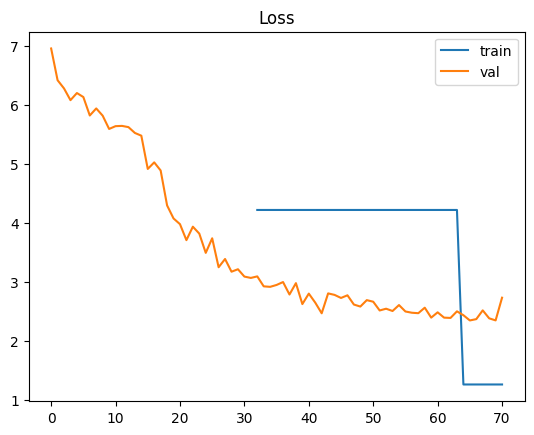

In [20]:
plt.plot(_train, label='train')
plt.plot(_val, label='val')
plt.title("Loss")
plt.legend()
plt.show()